# Credit card fraud detection Kaggle dataset

* https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3

Code which inspired this notebook:
* https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now
* http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

In [2]:
# timing helper functions

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [3]:
# set up parallel cluster using ipyparallel engines.
# ipcluster start
import ipyparallel as ipp
from ipyparallel import require
c = ipp.Client(profile='default')
v = c[:]
#print("engines running:",v)
print("engines running:",len(v))

/Users/scheckley/anaconda3/lib/python3.6/site-packages/ipyparallel/util.py:208: RuntimeWarning: IPython could not determine IPs for vii19567: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
/Users/scheckley/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@vii19567')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


TimeoutError: Hub connection request timed out

## Load the data and clean it up

In [8]:
data = pd.read_csv("data/creditcard.csv")

In [9]:
normamount = np.array(data['Amount'])
normamount = StandardScaler().fit_transform(normamount.reshape(-1,1))
data['normamount'] = normamount
del data['Amount']
del data['Time']
data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normamount
0,-1.4,-0.1,2.5,1.4,-0.3,0.5,0.2,0.1,0.4,0.1,...,-0.0,0.3,-0.1,0.1,0.1,-0.2,0.1,-0.0,0,0.2
1,1.2,0.3,0.2,0.4,0.1,-0.1,-0.1,0.1,-0.3,-0.2,...,-0.2,-0.6,0.1,-0.3,0.2,0.1,-0.0,0.0,0,-0.3
2,-1.4,-1.3,1.8,0.4,-0.5,1.8,0.8,0.2,-1.5,0.2,...,0.2,0.8,0.9,-0.7,-0.3,-0.1,-0.1,-0.1,0,1.2
3,-1.0,-0.2,1.8,-0.9,-0.0,1.2,0.2,0.4,-1.4,-0.1,...,-0.1,0.0,-0.2,-1.2,0.6,-0.2,0.1,0.1,0,0.1
4,-1.2,0.9,1.5,0.4,-0.4,0.1,0.6,-0.3,0.8,0.8,...,-0.0,0.8,-0.1,0.1,-0.2,0.5,0.2,0.2,0,-0.1
5,-0.4,1.0,1.1,-0.2,0.4,-0.0,0.5,0.3,-0.6,-0.4,...,-0.2,-0.6,-0.0,-0.4,-0.2,0.1,0.3,0.1,0,-0.3
6,1.2,0.1,0.0,1.2,0.2,0.3,-0.0,0.1,0.5,-0.1,...,-0.2,-0.3,-0.2,-0.8,0.8,-0.3,0.0,0.0,0,-0.3
7,-0.6,1.4,1.1,-0.5,0.9,0.4,1.1,-3.8,0.6,1.2,...,1.9,-1.0,0.1,-0.6,-0.4,-0.1,-1.2,-1.1,0,-0.2
8,-0.9,0.3,-0.1,-0.3,2.7,3.7,0.4,0.9,-0.4,-0.4,...,-0.1,-0.3,-0.2,1.0,0.4,-0.4,0.0,0.1,0,0.0
9,-0.3,1.1,1.0,-0.2,0.5,-0.2,0.7,0.1,-0.7,-0.4,...,-0.2,-0.6,-0.1,-0.4,-0.1,0.1,0.2,0.1,0,-0.3


Elapsed time is 0.8478901386260986 seconds.


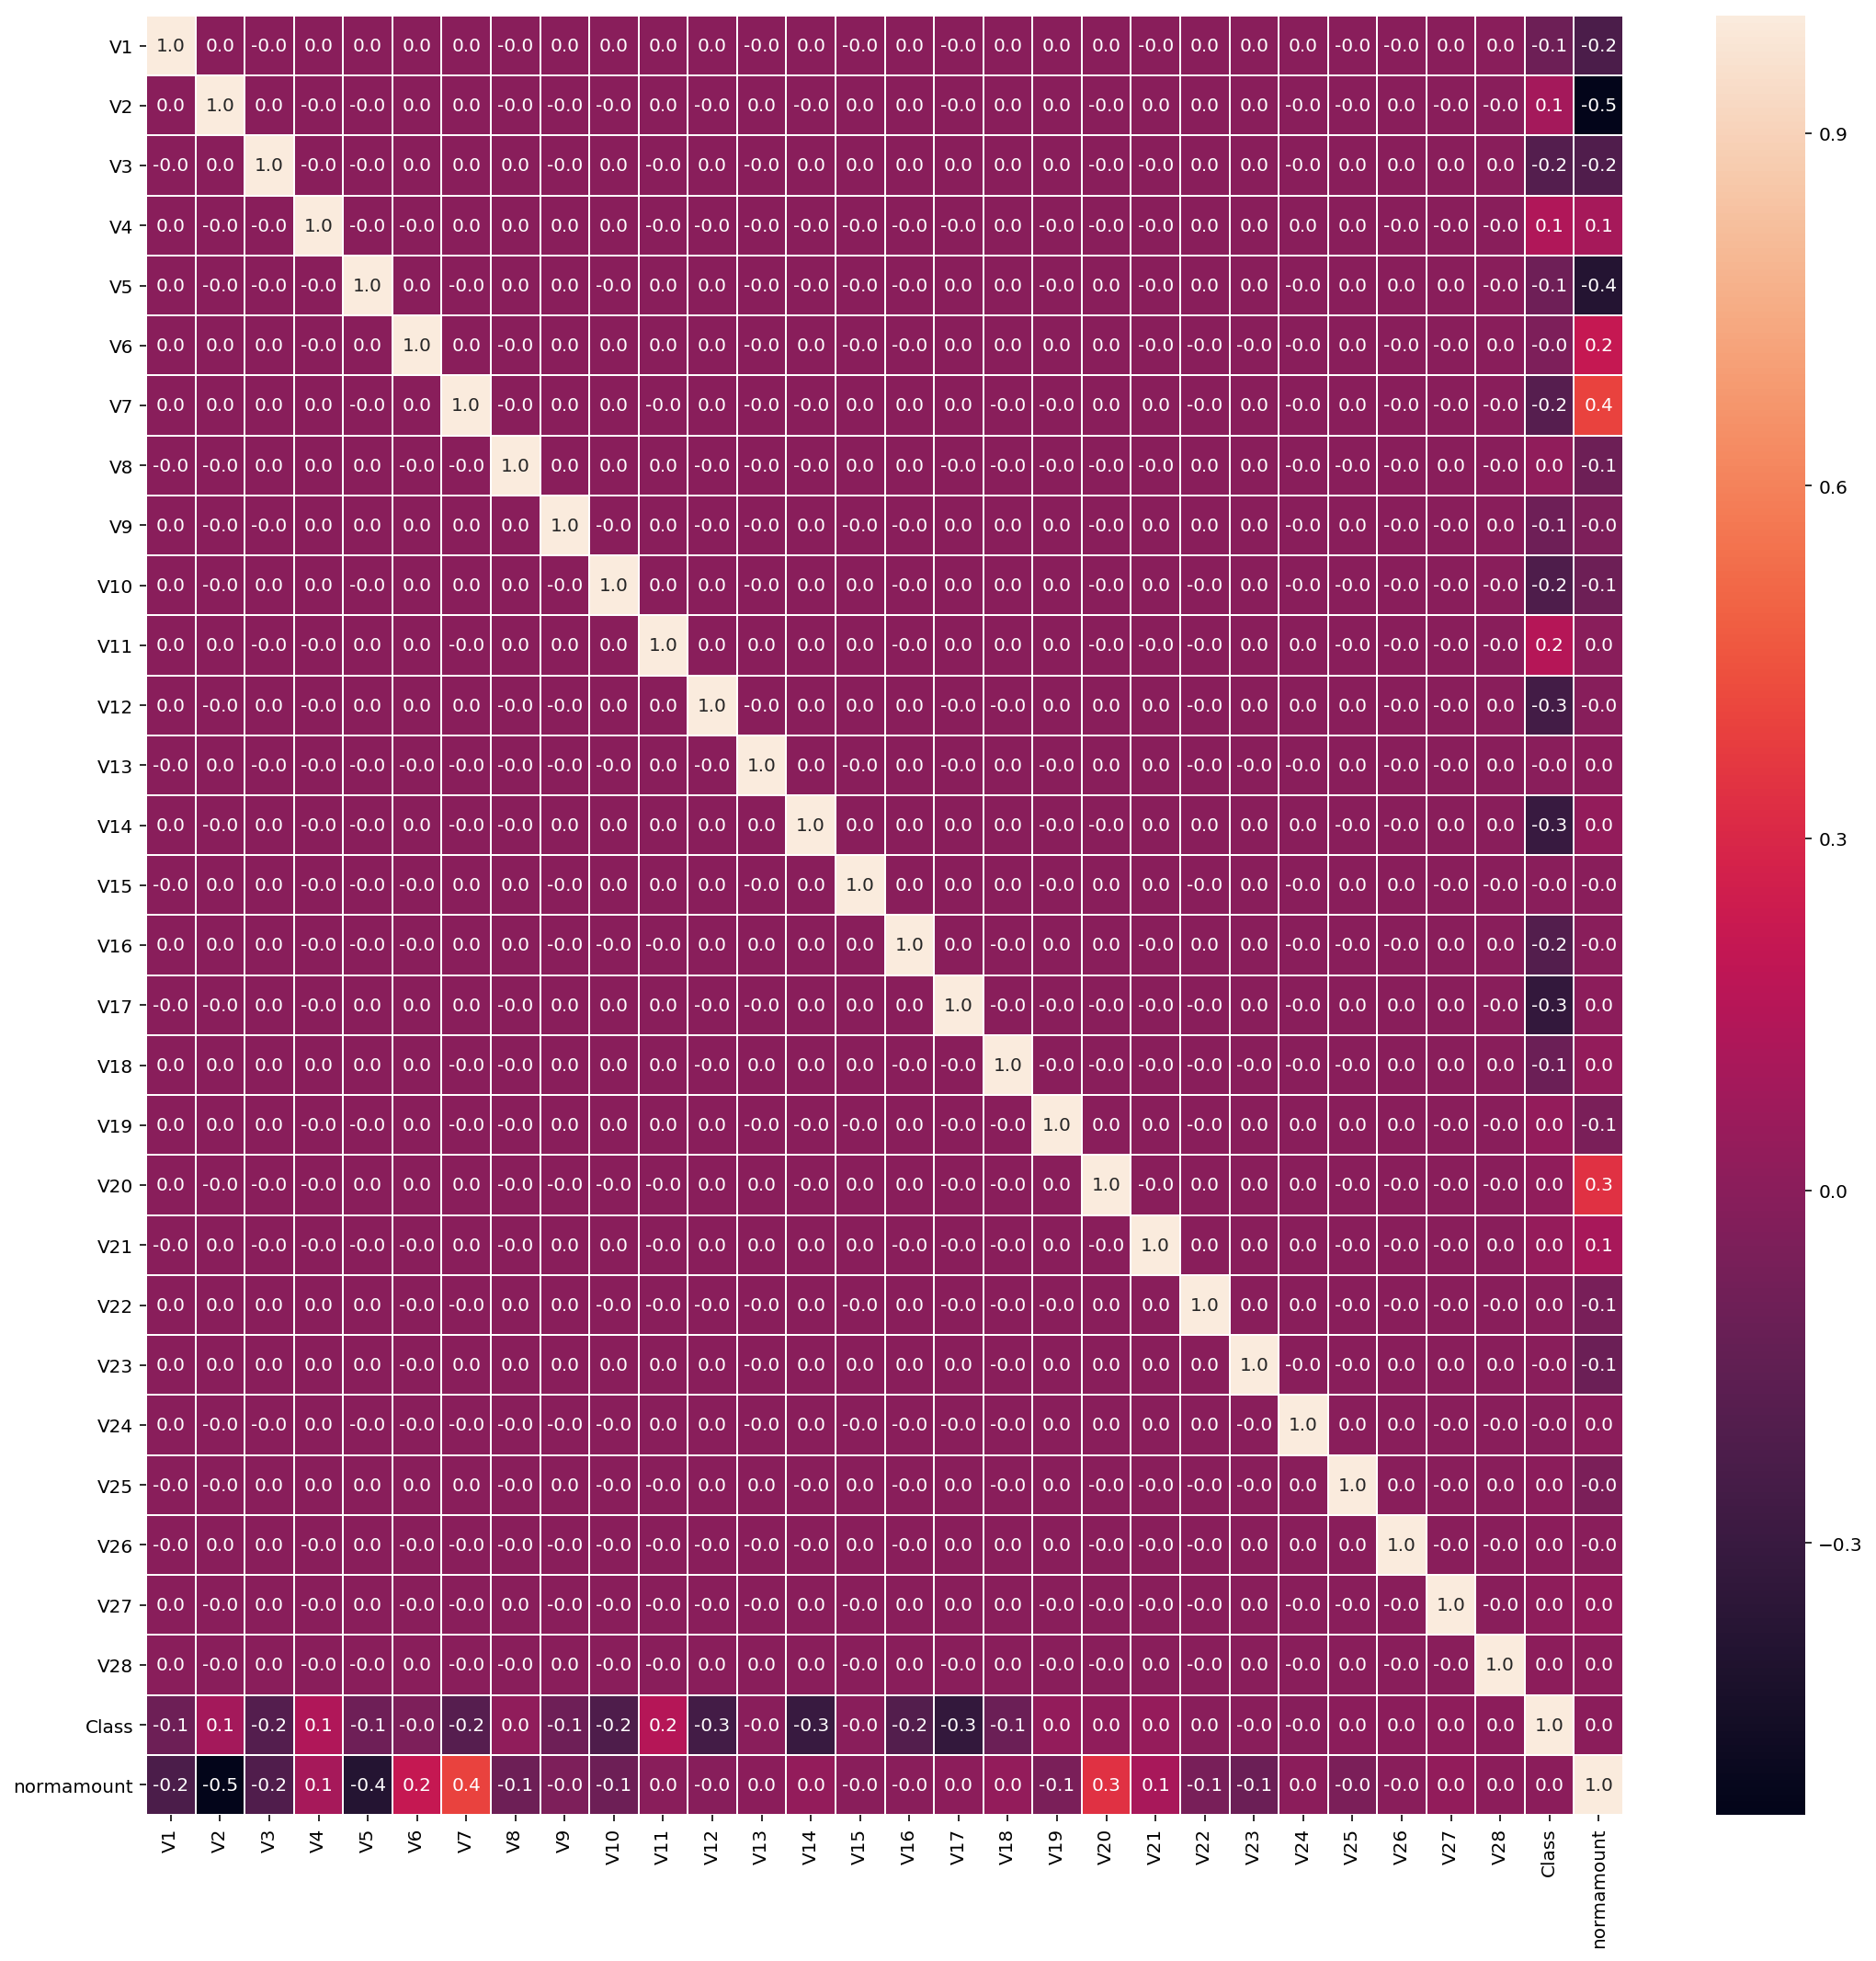

In [10]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

low correlation between features in this dataset.

In [8]:
#look at class imbalance
by_class = data.groupby('Class')
by_class.describe()

V1                                        V10       ...    V9  \
         count mean std   min  25%  50%  75% max    count mean  ...   75%   
Class                                                           ...         
0     284315.0  0.0 1.9 -56.4 -0.9  0.0  1.3 2.5 284315.0  0.0  ...   0.6   
1        492.0 -4.8 6.8 -30.6 -6.0 -2.3 -0.4 2.1    492.0 -5.7  ...  -0.8   

           normamount                                     
       max      count mean std  min  25%  50%  75%   max  
Class                                                     
0     15.6   284315.0 -0.0 1.0 -0.4 -0.3 -0.3 -0.0 102.4  
1      3.4      492.0  0.1 1.0 -0.4 -0.3 -0.3  0.1   8.1  

[2 rows x 232 columns]

The data appears to be quite heavily imbalanced as (obviously), fraudulent transactions should be relatively rare!

Can I use SMOTE over sampling to improve the balance of the data?

In [9]:
# http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.combine.SMOTEENN.html
# http://contrib.scikit-learn.org/imbalanced-learn/stable/combine.html#combine
from imblearn.combine import SMOTEENN
sm = SMOTEENN()

In [11]:
# split the features and target vector for resampling
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

In [12]:
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)

In [13]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normamount
0,-1.4,-0.1,2.5,1.4,-0.3,0.5,0.2,0.1,0.4,0.1,...,0.3,-0.0,0.3,-0.1,0.1,0.1,-0.2,0.1,-0.0,0.2
1,1.2,0.3,0.2,0.4,0.1,-0.1,-0.1,0.1,-0.3,-0.2,...,-0.1,-0.2,-0.6,0.1,-0.3,0.2,0.1,-0.0,0.0,-0.3
2,-1.4,-1.3,1.8,0.4,-0.5,1.8,0.8,0.2,-1.5,0.2,...,0.5,0.2,0.8,0.9,-0.7,-0.3,-0.1,-0.1,-0.1,1.2
3,-1.0,-0.2,1.8,-0.9,-0.0,1.2,0.2,0.4,-1.4,-0.1,...,-0.2,-0.1,0.0,-0.2,-1.2,0.6,-0.2,0.1,0.1,0.1
4,-1.2,0.9,1.5,0.4,-0.4,0.1,0.6,-0.3,0.8,0.8,...,0.4,-0.0,0.8,-0.1,0.1,-0.2,0.5,0.2,0.2,-0.1


In [17]:
tic()
#X_resampled, y_resampled = sm.fit_sample(X, y)
toc()
# this step takes a bit of time so I pickled the output

/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elapsed time is 594.5721569061279 seconds.


In [18]:
#pickle.dump(X_resampled, open( "X_resampled.pkl", "wb" ))
#pickle.dump(y_resampled, open( "y_resampled.pkl", "wb" ))

In [3]:
X_resampled = pickle.load(open( "X_resampled.pkl", "rb" ))
y_resampled = pickle.load(open( "y_resampled.pkl", "rb" ))

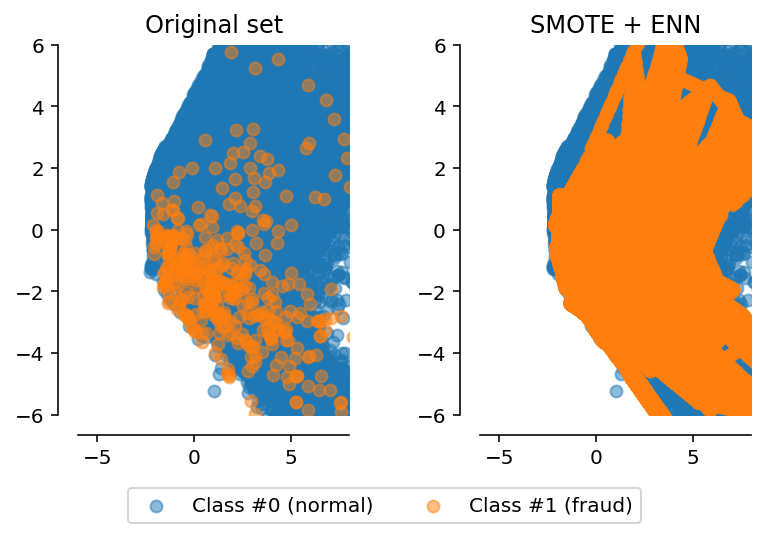

In [15]:
X_res_vis = pca.transform(X_resampled)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y['Class'] == 0, 0], X_vis[y['Class'] == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y['Class'] == 1, 0], X_vis[y['Class'] == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=0.5)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=0.5)
ax2.set_title('SMOTE + ENN')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

f.legend((c0, c1), ('Class #0 (normal)', 'Class #1 (fraud)'), loc='lower center',
         ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

Prep the new resampled data for machine learning

In [70]:
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = 0.3, random_state = 0)

In [40]:
#t-SNE
#model = TSNE(n_components=2, verbose=0, n_iter=300)
#t = model.fit_transform(X) #(X_resampled)

In [42]:
#pickle.dump(t, open( "tsne_model.pkl", "wb" ))

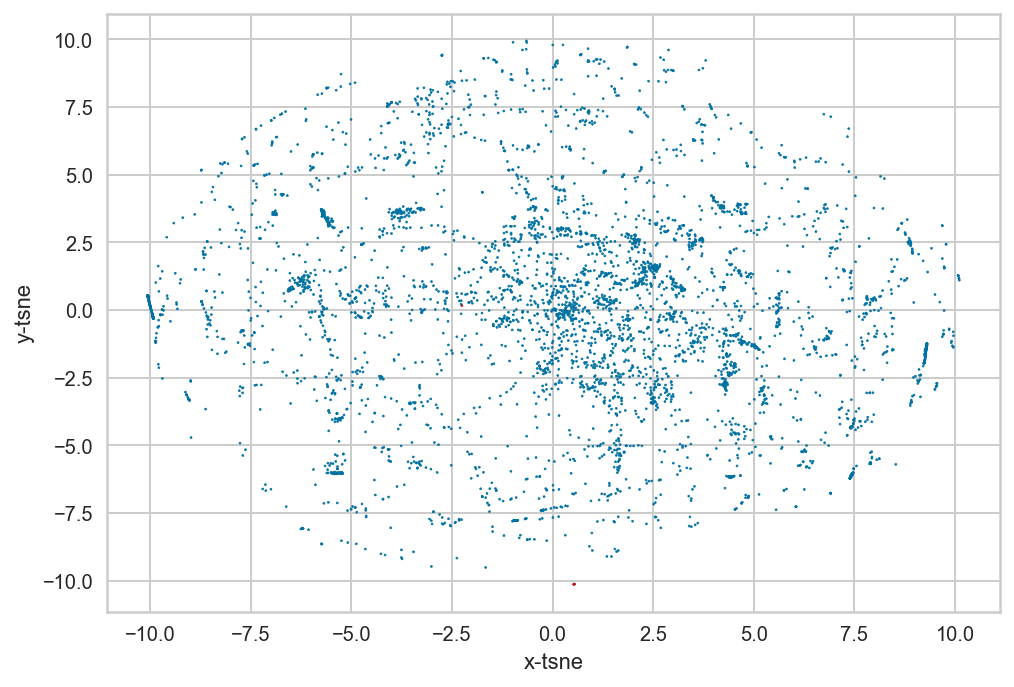

In [113]:
t = pickle.load(open( "tsne_model.pkl", "rb" ))
df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = t[:,0]
df_tsne['y-tsne'] = t[:,1]
df_tsne['target'] = y

df_tsne2 = df_tsne.head(5000)

colors = np.where(df_tsne.target > 0, 'r', 'b')


df_tsne2.plot.scatter(x='x-tsne',y='y-tsne', c=colors,s=1)

In [104]:
df_tsne.head()

,x-tsne,y-tsne,target
0,1.3,2.2,0
1,-9.8,1.6,0
2,6.3,4.5,0
3,6.7,-1.1,0
4,0.7,2.9,0


In [54]:
from tsne import bh_sne
vis_data = bh_sne(X)

ModuleNotFoundError: No module named 'tsne'

In [23]:
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

In [24]:
#lr = LogisticRegression(C = 0.01, penalty = 'l1')
#lr.fit(X_train,y_train)
#y_pred = lr.predict(X_test)

In [25]:
# try a grid search to find best parameters
from sklearn.model_selection import GridSearchCV
tic()
lr = LogisticRegression(C = 0.01, penalty = 'l1')
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100]}
lr = GridSearchCV(lr, param_grid=grid_values)
lr.fit(X_train,y_train)
print(lr.best_params_)

y_pred = lr.predict(X_test)
toc()

{'C': 1, 'penalty': 'l2'}
Elapsed time is 170.0603892803192 seconds.


In [26]:
# confusion matrix plotting function
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9178815236355546


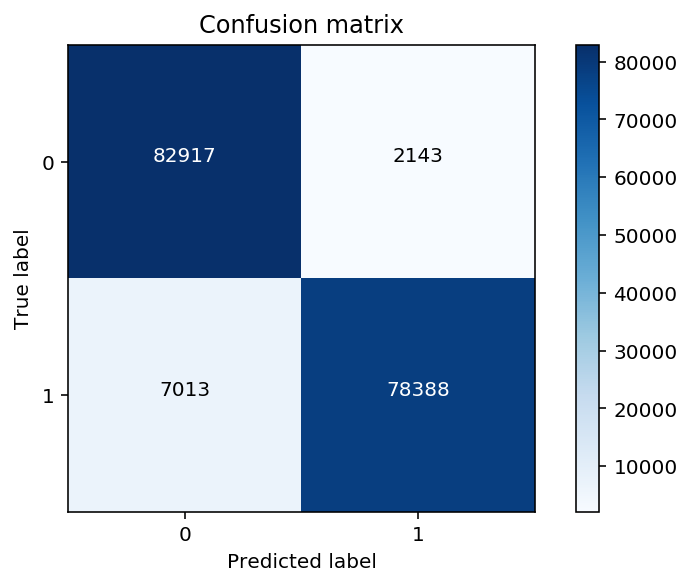

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# best recall metric = 0.915, with C=0.01
# improved to 0.919 with gridsearch finding l2 penalty and C=10.

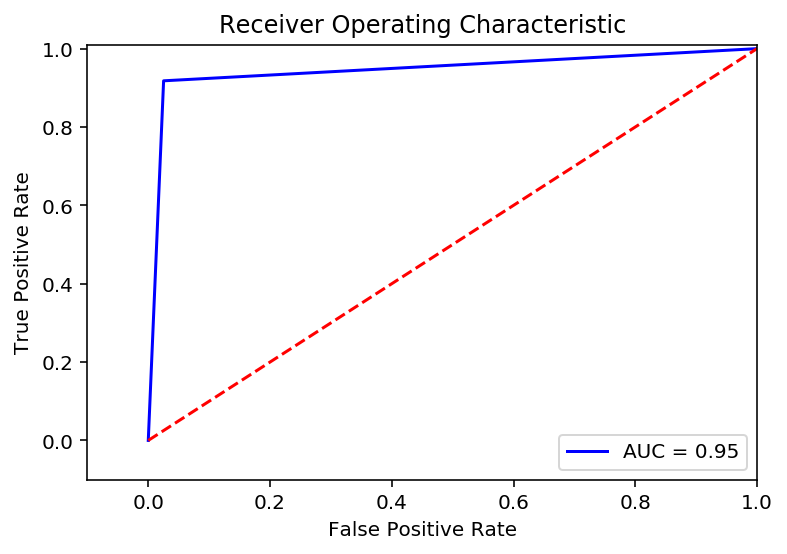

In [28]:
# ROC curve
lr = LogisticRegression(C = 10, penalty = 'l2')
y_pred_score = lr.fit(X_train,y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Tensor flow - 'cos everybody loves a neural network!

In [4]:
import tensorflow as tf
import tensorflow.contrib.learn as skflow
from tensorflow.python.data import Dataset
from sklearn import metrics
import pickle
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split

In [5]:
X_resampled = pickle.load(open( "X_resampled.pkl", "rb" ))
y_resampled = pickle.load(open( "y_resampled.pkl", "rb" ))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = 0.3, random_state = 0)

In [32]:
my_features = pd.DataFrame(X_resampled)
targets = pd.DataFrame(y_resampled)

my_features.columns = my_features.columns.astype(str)
targets.columns = targets.columns.astype(str)

In [34]:
# little script to automatically assign feature columns for Tensorflow as strings or ints.
import pandas.api.types as ptypes

my_columns = []

for col in my_features.columns:
  if ptypes.is_string_dtype(my_features[col]): #is_string_dtype is pandas function
    my_columns.append(tf.feature_column.categorical_column_with_hash_bucket(col, 
        hash_bucket_size= len(my_features[col].unique())))

  elif ptypes.is_numeric_dtype(my_features[col]): #is_numeric_dtype is pandas function
    my_columns.append(tf.feature_column.numeric_column(col))

In [35]:
feature_columns = my_columns

In [36]:
my_features.shape, targets.shape

((568202, 29), (568202, 1))

In [37]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/g8/kssh14_n04b8111tck8b_6qr0000gn/T/tmp5qbvm7le', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12df05160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [38]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [44]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=my_features, #construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets, 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets, 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets, 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [45]:
linear_regressor = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=my_features,
    training_targets=targets,
    validation_examples=X_test,
    validation_targets=y_test)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/g8/kssh14_n04b8111tck8b_6qr0000gn/T/tmp6b014830', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11351eb70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
LogLoss (on training data):
INFO:tensorflow:Calling model_fn.


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().